# Introduction
The idea of this notebook is to explore a step-by-step approach to create a <b>K-Nearest Neighbors Algorithm</b> without the help of any third party library. In practice, this Algorithm should be useful enough for us to classify our data whenever we have already made clusters (in this case color) which will serve as a starting point to find neighbors.

## 1. Working Data

In [1]:
# Data to learn
library(readr)
RGB <- as.data.frame(read_csv("RGB.csv"))
RGB$x <- as.numeric(RGB$x)
RGB$y <- as.numeric(RGB$y)
print("Working data ready")

Parsed with column specification:
cols(
  x = col_double(),
  y = col_double(),
  Class = col_character()
)



[1] "Working data ready"


### 1.1 Train and test sample generation

We will create 2 different sample sets:
- <b>Training Set:</b> This will contain 75% of our working data, selected randomly. This set will be used to train our model.
- <b>Test Set:</b> Remaining 25% of our working data, which will be used to test the accuracy of our model. In other words, once our predictions of this 25% are made, will check the "<i>percentage of correct classifications</i>" by comparing predictions versus real values.

In [2]:
# Training Dataset
smp_siz = floor(0.75*nrow(RGB))
train_ind = sample(seq_len(nrow(RGB)),size = smp_siz)
train =RGB[train_ind,]

# Test Dataset
test=RGB[-train_ind,]
OriginalTest <- test
paste("Training and test sets done")

[1] "Training and test sets done"

### 1.2 Train Data
We can observe that our train data is classified in 3 clusters based on colors.

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



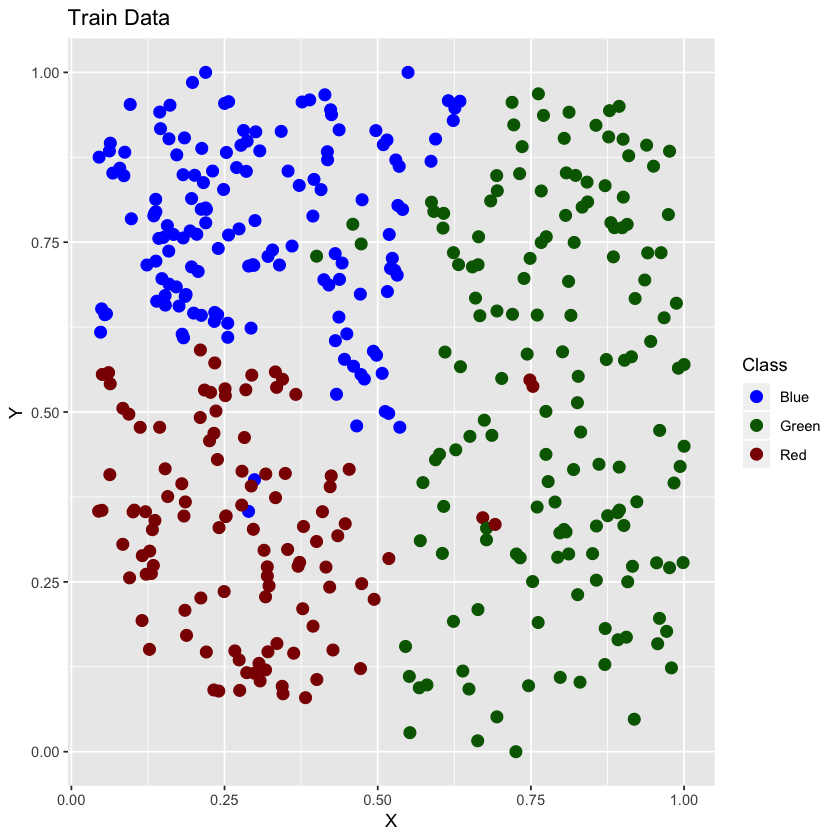

In [3]:
# We plot test colored datapoints
library(ggplot2)
colsdot <- c("Blue" = "blue", "Red" = "darkred", "Green" = "darkgreen")
ggplot() + 
  geom_tile(data=train,mapping=aes(x, y), alpha=0) +
  ##Ad tiles according to probabilities
  ##add points
  geom_point(data=train,mapping=aes(x,y, colour=Class),size=3 ) + 
  scale_color_manual(values=colsdot) +
  #add the labels to the plots
  xlab('X') + ylab('Y') + ggtitle('Train Data')+
  #remove grey border from the tile
  scale_x_continuous(expand=c(0,.05))+scale_y_continuous(expand=c(0,.05))

### 1.2 Test Data
Even though we actually know the color classification of our test data, we will try to create a model that's able to guess it's true color. For this, we will save our tests colors and compare them with our predictions to calculate our <b>Model Accuracy</b>.

Note: we have purposely forgot it's classification colors in order to create a model that's able to guess it

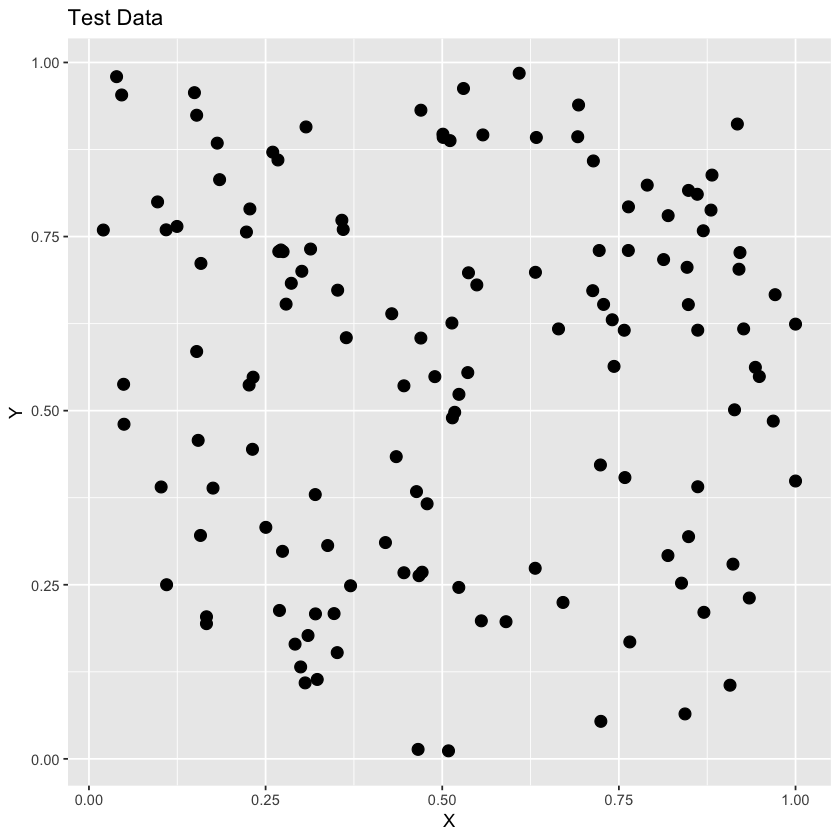

In [4]:
# We plot test colored datapoints
library(ggplot2)
colsdot <- c("Blue" = "blue", "Red" = "darkred", "Green" = "darkgreen")
ggplot() + 
  geom_tile(data=test,mapping=aes(x, y), alpha=0) +
  ##Ad tiles according to probabilities
  ##add points
  geom_point(data=test,mapping=aes(x,y),size=3 ) + 
  scale_color_manual(values=colsdot) +
  #add the labels to the plots
  xlab('X') + ylab('Y') + ggtitle('Test Data')+
  #remove grey border from the tile
  scale_x_continuous(expand=c(0,.05))+scale_y_continuous(expand=c(0,.05))
cat("Note: we have purposely forgot it's classification colors in order to create a model that's able to guess it")

## 2. K-Nearest Neighbors Algorithm

Below is a step-by-step example of an implementation of this algorithm.
What we want to achieve is for each selected gray point above (our test values), where we allegedly don't know it's true color, find the nearest neighbor or nearest colored paint (from our train values) and assign the same color as this one.

<b>In particular, we need to:</b>
- <b>Normalize data:</b> even though in this case is not really needed, since all values are in the same scale (decimals between 0 and 1), it's recommended to normalize in order to have a "standard distance metric".
- <b>Define how we measure distance:</b> We can define the distance between two points in this 2 dimensional data set as the Euclidean distance between them. We will calculate both L1 (sum of absolute differences) and L2 (sum of squared differences) distances, though final results will be calculated using L2 since it's more unforgiving than L1.
- <b>Calculate Distances:</b> we need to calculate distance between each tested data point and every value within our train dataset. Normalization is key here since for example, in the case of body structure, a distance in weight (1 KG) and height (1 M) is not comparable. For such case we can anticipate a higher deviation in KG than it is on the Meters, leading to incorrect overall distances.
- <b>Sort Distances:</b> Once we calculate the distance between every test and training points, we need to sort them in descending order.
- <b>Selecting top K nearest neighbors:</b> We select the top K nearest points and in order to inspect which category (colors) they belonged in order to assign this category to our tested point. Since we select multiple "neighbors" we might end up with multiple categories, in which case, we can calculate a probability.

In [5]:
# We define a function for prediction
KnnL2Prediction <- function(x,y,K) {
    
  # Train data
  Train <- train
  # This matrix will contain all X,Y values that we want test.
  Test <- data.frame(X=x,Y=y)
    
  # Data normalization
  Test$X <- (Test$X - min(Train$x))/(min(Train$y) - max(Train$x))
  Test$Y <- (Test$Y - min(Train$y))/(min(Train$y) - max(Train$y))
  Train$x <- (Train$x - min(Train$x))/(min(Train$x) - max(Train$x))
  Train$y <- (Train$y - min(Train$y))/(min(Train$y) - max(Train$y))

  # We will calculate L1 and L2 distances between Test and Train values.
  VarNum <- ncol(Train)-1
  L1 <- 0
  L2 <- 0
  for (i in 1:VarNum) {
    L1 <- L1 + (Train[,i] - Test[,i])
    L2 <- L2 + (Train[,i] - Test[,i])^2
  }
    
  # We will use L2 Distance
  L2 <- sqrt(L2)
  
  # We add labels to distances and sort
  Result <- data.frame(Label=Train$Class,L1=L1,L2=L2)
  
  # We sort data based on score
  ResultL1 <-Result[order(Result$L1),]
  ResultL2 <-Result[order(Result$L2),]
  
  # Return Table of Possible classifications
  a <- prop.table(table(head(ResultL2$Label,K)))
  b <- as.data.frame(a)
  return(as.character(b$Var1[b$Freq == max(b$Freq)]))
}
print("Function loaded")

[1] "Function loaded"


## 3. Finding the correct K paremeter using Cross Validation

For this we will use a method called "cross validation".
What this means is that we will make predictions within the training data itself and iterate this on many different values of K for many different folds or permutations of the data.


<img src="images/crossvalidation.png" width="50%" />

In [6]:
# We will use 5 folds
FoldSize = floor(0.2*nrow(train)) 

# Fold1
piece1 = sample(seq_len(nrow(train)),size = FoldSize ) 
Fold1 = train[piece1,]
rest = train[-piece1,] 

# Fold2
piece2 = sample(seq_len(nrow(rest)),size = FoldSize)
Fold2 = rest[piece2,]
rest = rest[-piece2,] 

# Fold3
piece3 = sample(seq_len(nrow(rest)),size = FoldSize)
Fold3 = rest[piece3,]
rest = rest[-piece3,] 

# Fold4
piece4 = sample(seq_len(nrow(rest)),size = FoldSize)
Fold4 = rest[piece4,]
rest = rest[-piece4,] 

# Fold5
Fold5 <- rest

# We make folds
Split1_Test <- rbind(Fold1,Fold2,Fold3,Fold4)
Split1_Train <- Fold5

Split2_Test <- rbind(Fold1,Fold2,Fold3,Fold5)
Split2_Train <- Fold4

Split3_Test <- rbind(Fold1,Fold2,Fold4,Fold5)
Split3_Train <- Fold3

Split4_Test <- rbind(Fold1,Fold3,Fold4,Fold5)
Split4_Train <- Fold2

Split5_Test <- rbind(Fold2,Fold3,Fold4,Fold5)
Split5_Train <- Fold1

# We select best K
OptimumK <- data.frame(K=NA,Accuracy=NA,Fold=NA)
results <- train

for (i in 1:5) {
  if(i == 1) {
    train <- Split1_Train
    test <- Split1_Test
  } else if(i == 2)  {
    train <- Split2_Train
    test <- Split2_Test
  } else if(i == 3)  {
    train <- Split3_Train
    test <- Split3_Test
  } else if(i == 4)  {
    train <- Split4_Train
    test <- Split4_Test
  } else if(i == 5)  {
    train <- Split5_Train
    test <- Split5_Test
  }
    for(j in 1:20) {
      results$Prediction <- mapply(KnnL2Prediction, results$x, results$y,j)
      # We calcuylate accuracy
      results$Match <- ifelse(results$Class == results$Prediction, 1, 0)
      Accuracy <- round(sum(results$Match)/nrow(results),4)
      OptimumK <- rbind(OptimumK,data.frame(K=j,Accuracy=Accuracy,Fold=paste("Fold",i)))
    
    }
}
print("Cross Validation Generated")

[1] "Cross Validation Generated"


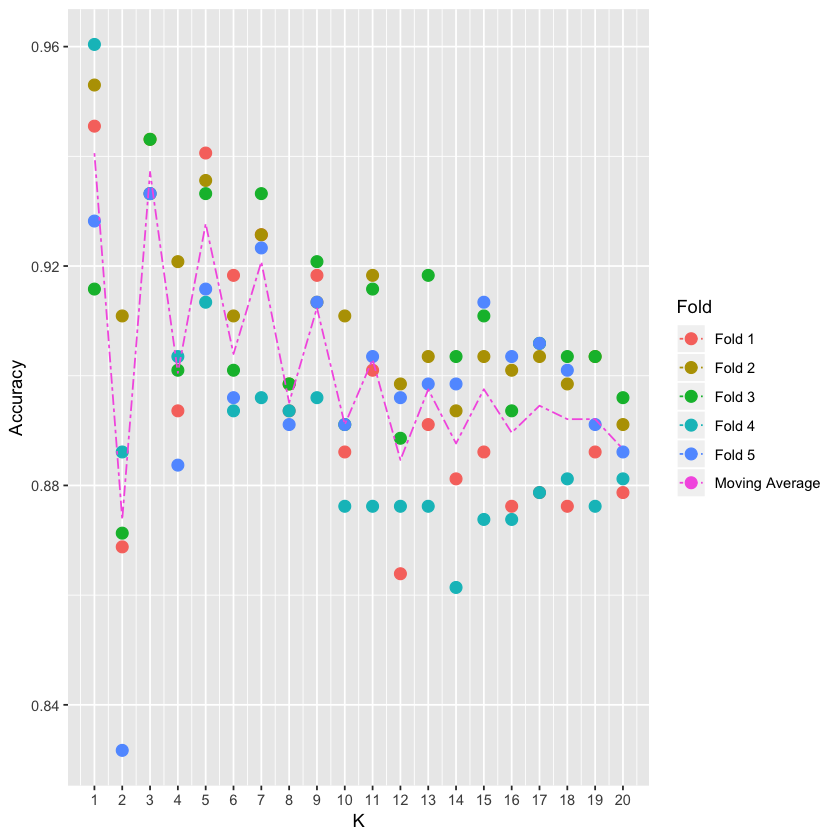

In [7]:
OptimumK <- OptimumK [-1,]
MeanK <- aggregate(Accuracy ~ K, OptimumK, mean)
ggplot() + 
  geom_point(data=OptimumK,mapping=aes(K,Accuracy, colour=Fold),size=3 ) +
  geom_line(aes(K, Accuracy, colour="Moving Average"), linetype="twodash", MeanK) +
  scale_x_continuous(breaks=seq(1, max(OptimumK$K), 1))

As seen in the plot above, we can observe that prediction accuracy of our algorithm is in the range of 88%-95% for all fields and decreasing from K=3 onwards. It appears that we can observe highest consistent accuracy results on K=1 (3 is also a good alternative).

## 4. Predicting based on Top 1 Nearest Neighbors.

### 4.1 Model Accuracy

In [8]:
# Predictions over our Test sample
test <- OriginalTest
K <- 1
test$Prediction <- mapply(KnnL2Prediction, test$x, test$y,K)
head(test,10)

# We calculate accuracy
test$Match <- ifelse(test$Class == test$Prediction, 1, 0)
Accuracy <- round(sum(test$Match)/nrow(test),4)
print(paste("Accuracy of ",Accuracy*100,"%",sep=""))

x         y         Class Prediction
2  0.2277574 0.7896829 Blue  Blue      
8  0.2790062 0.6529734 Blue  Blue      
9  0.2228817 0.7565315 Blue  Blue      
15 0.2686533 0.7286139 Blue  Blue      
18 0.1849045 0.8317273 Blue  Blue      
19 0.1492896 0.9566455 Blue  Blue      
22 0.1584791 0.7114385 Blue  Blue      
26 0.2601053 0.8712044 Blue  Blue      
31 0.1245759 0.7645414 Blue  Blue      
34 0.2716716 0.7307672 Blue  Blue

[1] "Accuracy of 93.33%"


As seen by the results above, we can expect to "guess the correct class" 93% of the times.

### 4.2 Test Data Prediction

<b>4.2.1 Original Colored Test Values</b>

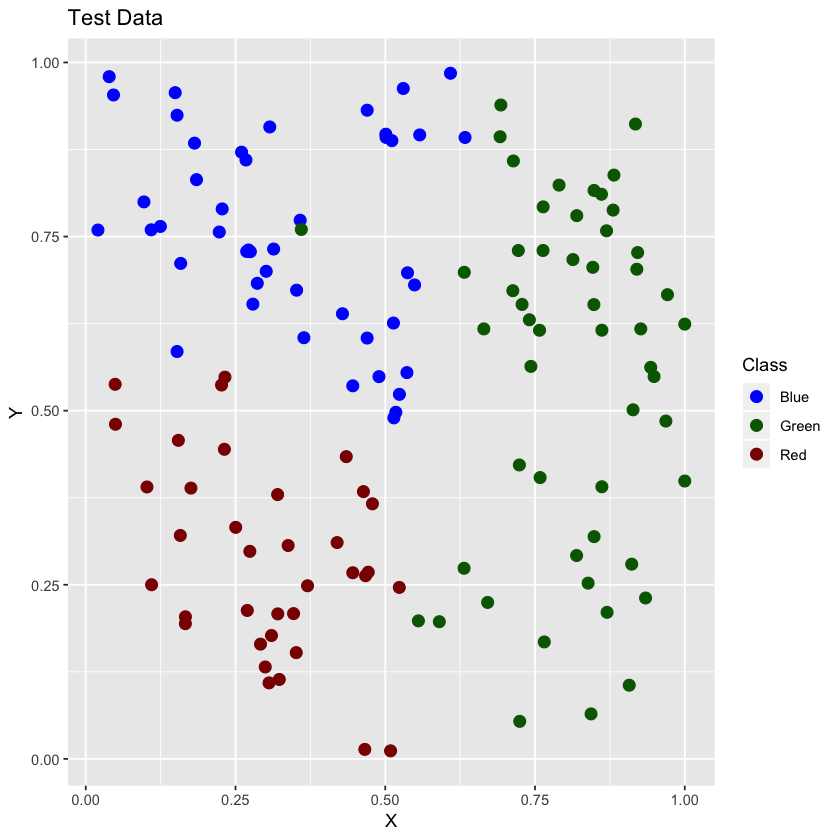

In [9]:
ggplot() + 
  geom_tile(data=test,mapping=aes(x, y), alpha=0) +
  geom_point(data=test,mapping=aes(x,y,colour=Class),size=3 ) + 
  scale_color_manual(values=colsdot) +
  xlab('X') + ylab('Y') + ggtitle('Test Data')+
  scale_x_continuous(expand=c(0,.05))+scale_y_continuous(expand=c(0,.05))

<b>4.2.1 Predicted Colored Test Values</b>

Predicted (colored) values

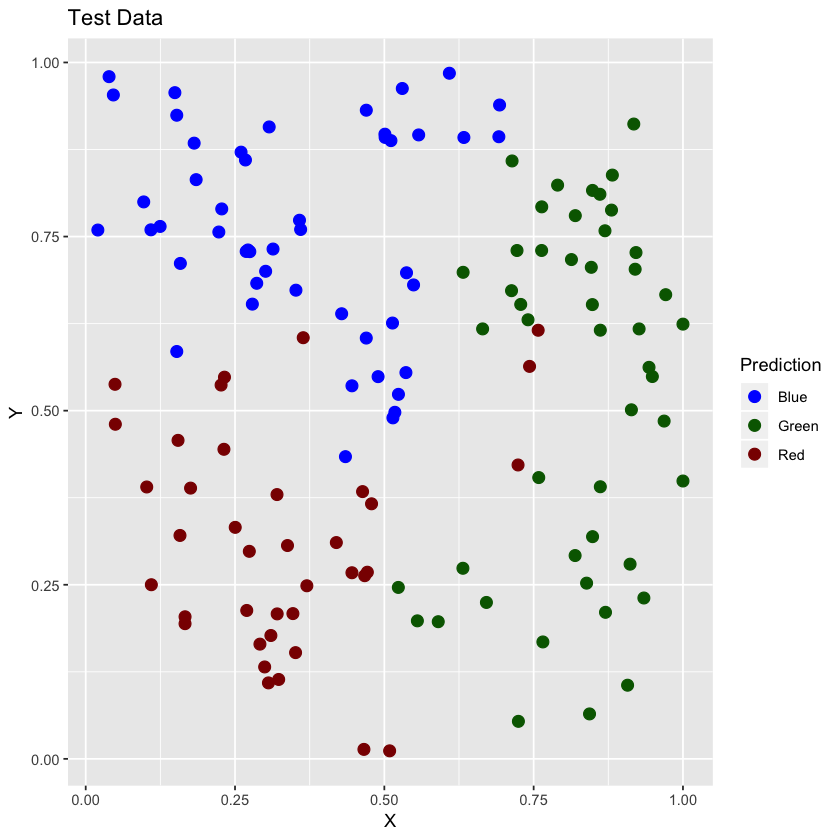

In [11]:
ggplot() + 
  geom_tile(data=test,mapping=aes(x, y), alpha=0) +
  geom_point(data=test,mapping=aes(x,y,colour=Prediction),size=3 ) + 
  scale_color_manual(values=colsdot) +
  xlab('X') + ylab('Y') + ggtitle('Test Data')+
  scale_x_continuous(expand=c(0,.05))+scale_y_continuous(expand=c(0,.05))
cat("Predicted (colored) values")

<b>4.2.1 Decision Limits</b>

Finally, we can visualize our "decision limits" over our original Test Dataset. This provides a good visual approximation as how well our model is classifying our data and which are the limits of it's classification space.

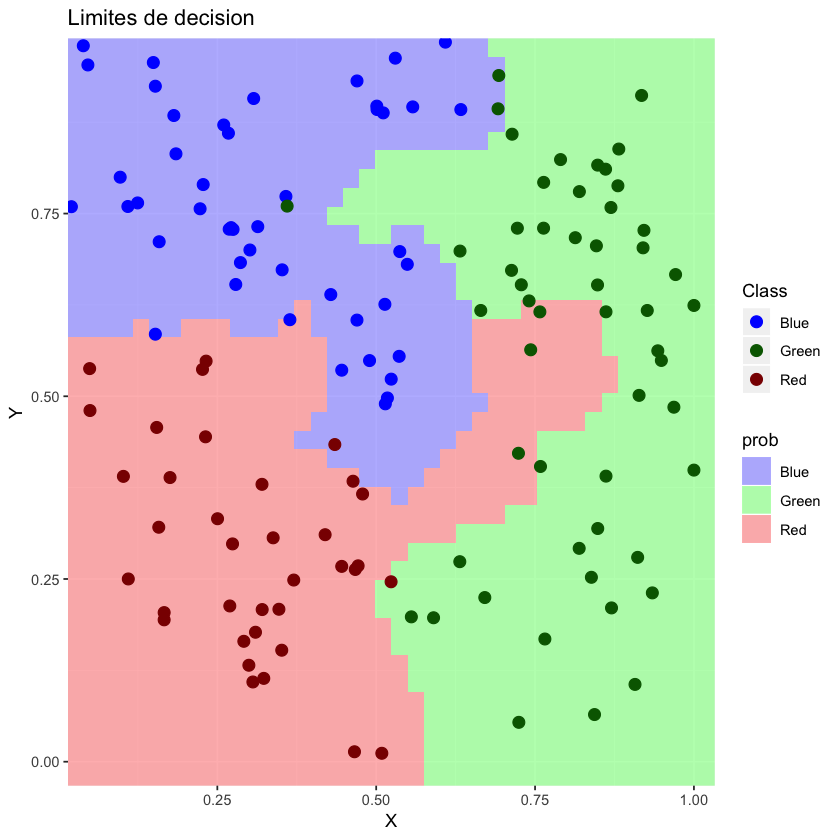

In [12]:
# We calculate background colors
x_coord = seq(min(train[,1]) - 0.02,max(train[,1]) + 0.02,length.out = 40)
y_coord = seq(min(train[,2]) - 0.02,max(train[,2]) + 0.02, length.out = 40)
coord = expand.grid(x = x_coord, y = y_coord)
coord[['prob']] = mapply(KnnL2Prediction, coord$x, coord$y,K)

# We calculate predictions and plot decition area
colsdot <- c("Blue" = "blue", "Red" = "darkred", "Green" = "darkgreen")
colsfill <- c("Blue" = "#aaaaff", "Red" = "#ffaaaa", "Green" = "#aaffaa")
ggplot() + 
  ##Ad tiles according to probabilities
  geom_tile(data=coord,mapping=aes(x, y, fill=prob), alpha=0.8) +
  ##add points
  geom_point(data=test,mapping=aes(x,y, colour=Class),size=3 ) + 
  scale_color_manual(values=colsdot) +
  scale_fill_manual(values=colsfill) +
  #add the labels to the plots
  xlab('X') + ylab('Y') + ggtitle('Decision Limits')+
  #remove grey border from the tile
  scale_x_continuous(expand=c(0,0))+scale_y_continuous(expand=c(0,0))

## 5. Final Thoughts
K-Nearest Neighbors is a very simple algorithm which seems to provide very good results. Even though we can clearly classify items by eye here, this model also works in cases of higher dimensions where we cannot simply observe them by naked eye. For this to work, we need to have a Train data sample with <b>existing classifications</b>, which we will later use to classify data around it, meaning it's a <b>supervised machine learning algorithm</b>.

Sadly, this method presents some difficulties in scenarios such as in the presence of complex patterns which cannot be represented by simple radial distance, such as the cases of outliers presence or radial or nested clusters. It also has the problem of performance, since for every classification of a new data point, we need to compare it to every single point in our Train data which is resource and time intensive, since it requires replication and iteration of the complete training dataset.
